Epoch 1/5
Loss: 0.7099, Accuracy: 47.79%
Epoch 2/5
Loss: 0.6462, Accuracy: 67.26%
Epoch 3/5
Loss: 0.5796, Accuracy: 76.99%
Epoch 4/5
Loss: 0.5387, Accuracy: 78.76%
Epoch 5/5
Loss: 0.4852, Accuracy: 84.07%


C:\Users\RTX\AppData\Local\Temp\ipykernel_11012\3818407970.py:116: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('efficientnet_b0_model.pth'

Classification Report:
              precision    recall  f1-score   support

      Caries       0.62      0.28      0.38        29
 Non Carious       0.46      0.78      0.58        23

    accuracy                           0.50        52
   macro avg       0.54      0.53      0.48        52
weighted avg       0.55      0.50      0.47        52



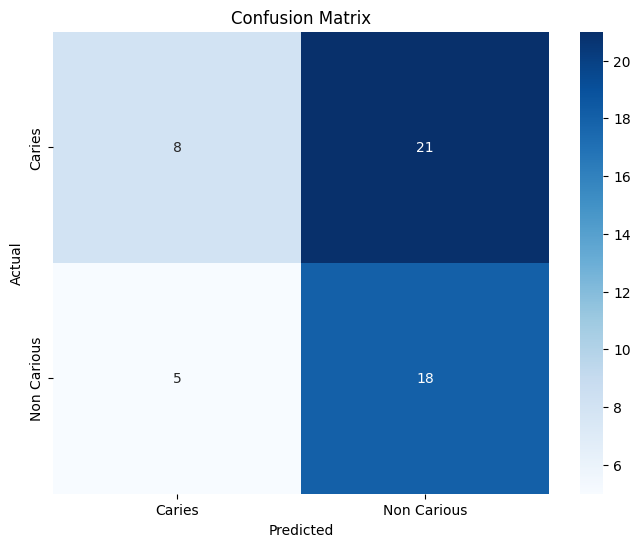

Evaluation complete.


In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set paths
train_dir = r'd:\paper code\gu data\train'
test_dir = r'd:\paper code\gu data\test'

# Image Dataset Class
class ImageDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.class_names = sorted(os.listdir(data_dir))
        self.image_paths = []
        self.labels = []

        for label, class_name in enumerate(self.class_names):
            class_dir = os.path.join(data_dir, class_name)
            for file_name in os.listdir(class_dir):
                self.image_paths.append(os.path.join(class_dir, file_name))
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        try:
            image = Image.open(image_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image: {image_path}, error: {e}")
            return None, None
        
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Data Transformations with Augmentations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

# Create Datasets and Loaders
train_dataset = ImageDataset(train_dir, transform=transform)
test_dataset = ImageDataset(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)  # num_workers=0 for debugging
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)   # num_workers=0 for debugging

# Load EfficientNet-B0 Model (with classifier adapted to 2 output classes)
model = models.efficientnet_b2(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)  # Modify the final layer to match the number of classes

# Move model to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training Loop
epochs = 5

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    model.train()
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        if images is None or labels is None:
            continue  # Skip corrupted images
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Calculate running loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    print(f"Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

    # Save the model after each epoch or optionally after the last epoch
    torch.save(model.state_dict(), 'efficientnet_b0_model.pth')

# Load the model for evaluation
model.load_state_dict(torch.load('efficientnet_b0_model.pth'))
model.eval()

# Test Loop
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        if images is None or labels is None:
            continue  # Skip corrupted images
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Classification Report and Confusion Matrix
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=train_dataset.class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.class_names, yticklabels=train_dataset.class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

print("Evaluation complete.")


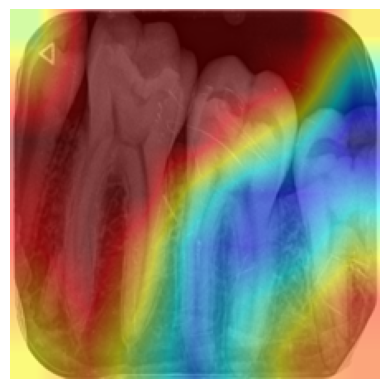

In [21]:
import torch
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

def generate_gradcam(model, image, class_idx, device):
    model.eval()

    # Register hooks
    model = register_hooks(model)
    
    # Forward pass
    image = image.unsqueeze(0).to(device)
    output = model(image)
    
    # Zero gradients
    model.zero_grad()

    # Backward pass
    class_score = output[0, class_idx]
    class_score.backward()

    # Get gradients and activations
    activations_np = activations.cpu().detach().numpy()[0]  # Shape: (num_channels, H, W)
    gradients_np = gradients.cpu().detach().numpy()[0]       # Shape: (num_channels, H, W)

    # Compute weights
    weights = np.mean(gradients_np, axis=(1, 2))  # Averaging across spatial dimensions (H, W)

    # Compute Grad-CAM
    cam = np.zeros(activations_np.shape[1:], dtype=np.float32)  # (H, W)
    
    for i in range(weights.shape[0]):
        cam += weights[i] * activations_np[i, :, :]  # (H, W)
    
    # Apply ReLU
    cam = np.maximum(cam, 0)

    # Normalize and resize
    cam = cv2.resize(cam, (224, 224))  # Resize to input size
    cam -= np.min(cam)
    cam /= np.max(cam)
    
    return cam

def overlay_gradcam(image_path, gradcam):
    image = Image.open(image_path).convert("RGB")
    image = image.resize((224, 224))
    image = np.array(image)

    # Convert Grad-CAM to RGB
    heatmap = cv2.applyColorMap(np.uint8(255 * gradcam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(image) / 255
    cam = cam / np.max(cam)
    
    # Display
    plt.imshow(cam)
    plt.axis('off')
    plt.show()

# Select an image and class index for Grad-CAM
test_image, _ = test_dataset[0]
class_idx = 0  # Replace with the appropriate class index

# Generate Grad-CAM
gradcam = generate_gradcam(model, test_image, class_idx, device)

# Overlay Grad-CAM on the image
image_path = os.path.join(test_dir, test_dataset.image_paths[8])  # Update the path
overlay_gradcam(image_path, gradcam)
